## <span style=color:blue>This notebook is doing pre-processing of the MONTHLY ML table, including getting all ranges into [0,1].  Then it uses several ML regression algorithms to create predictive models </span>

In [247]:
# pulled this long list from somewhere and added to it.  Not using everything here

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    f1_score,
)
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, 
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support, mean_squared_error, r2_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression



ImportError: cannot import name 'LightGBM' from 'sklearn.linear_model' (/Users/rick/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/linear_model/__init__.py)

<span style=color:blue>Importing the MONTHLY ML table </span>

In [200]:

archive_dir = '/Users/rick/AG-CODE--v03/ML-ARCHIVES--v01/'
ml_tables_dir = archive_dir + 'ML-TABLES--v01/'

ml_file = 'ML-table-monthly.csv'


df_ml = pd.read_csv(ml_tables_dir + ml_file)
print(df_ml.shape)
print(df_ml.head())

# Happily, there are no null values in my ML table
print(df_ml.isnull().values.any())
# yields False


(9952, 71)
   year state_name county_name  yield  nutr_ret_high  suit_irrig_high_soy  \
0  2022   ILLINOIS      BUREAU   67.5             10                10000   
1  2021   ILLINOIS      BUREAU   66.4             10                10000   
2  2020   ILLINOIS      BUREAU   64.8             10                10000   
3  2019   ILLINOIS      BUREAU   57.4             10                10000   
4  2018   ILLINOIS      BUREAU   68.5             10                10000   

   AEZ_1  AEZ_2  AEZ_3  AEZ_4  ...  month_05__PRECTOTCORR  month_05__GWETROOT  \
0      0      1      0      0  ...                  67.10            0.551000   
1      0      1      0      0  ...                  26.31            0.508333   
2      0      1      0      0  ...                 143.42            0.589333   
3      0      1      0      0  ...                 245.06            0.650667   
4      0      1      0      0  ...                  86.09            0.581667   

   month_05__EVPTRNS  month_05__ALLSKY_

<span style=color:blue>Separating my independent variables from my dependent variable     </span>

In [201]:
X = df_ml.drop(columns=['yield'])
y = df_ml.loc[:,['yield']]

print(X.shape)
print(y.shape)

# print(X.head())
# print(y.head())

(9952, 70)
(9952, 1)


<span style=color:blue>Separating a training set from a testing set    </span>

In [202]:
# For this pipeline I will do random shuffling of the input records before separating the test set
# Choosing random_state=0 (or any specific integer) will ensure that different runs will use same shuffle

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# keeping a copy of y_test, because it may get modified below
y_test_orig = y_test.copy()

print(X_train.head())
print(y_train.head())
print(X_test.head())
print(y_test.head())
print()
print(y_test_orig.head())
# note: index of first row in y_test_orig is 7397)

print()
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print()
print(y_test.iloc[0,0])

      year state_name county_name  nutr_ret_high  suit_irrig_high_soy  AEZ_1  \
3464  2010    INDIANA    DEARBORN             10                10000      0   
735   2007   ILLINOIS      PEORIA             10                10000      0   
7415  2006   NEBRASKA      PIERCE             10                10000      0   
1282  2014   ILLINOIS     DOUGLAS             10                10000      0   
9437  2012       OHIO     CARROLL              9                10000      0   

      AEZ_2  AEZ_3  AEZ_4  AEZ_5  ...  month_05__PRECTOTCORR  \
3464      0      1      0      0  ...                  12.13   
735       1      0      0      0  ...                  36.28   
7415      0      0      0      0  ...                 132.70   
1282      0      0      0      0  ...                 102.66   
9437      0      0      0      0  ...                 121.84   

      month_05__GWETROOT  month_05__EVPTRNS  month_05__ALLSKY_SFC_PAR_TOT  \
3464            0.402333           0.083667              

<span style=color:blue>"Normalizing" all the scalar values.  Using StandardScalar, which maps the data to have a mean of 0 and standard deviation of 1.  Will use MinMaxScaler below </span>

<span style=color:blue>Note: probably I should have done the scaling before separating the training from the test sets.  One reason I am doing it here is that below I will switch to MinMaxScaler, and make an interesting observation.</span>

In [203]:
X_train = X_train.drop(columns=['year','state_name','county_name'])
X_test = X_test.drop(columns=['year','state_name','county_name'])


scalerXST = StandardScaler().fit(X_train)
scaleryST = StandardScaler().fit(y_train)

X_trainST = scalerXST.transform(X_train)
y_trainST = scaleryST.transform(y_train)
X_testST = scalerXST.transform(X_test)
y_testST = scaleryST.transform(y_test)



<span style=color:blue>How to get back to original values of y_test ...    </span>

In [204]:
# testing how inverse of the scaling is working

# basically, if scalery was your scaling function, then use scalery.inverse_transform;
#   NOTE: this works on a sequence

print(df_ml.iloc[7397]['yield'])   #  the first entry in y_test has index 1277 from df_ml
print(y_testST[0]) #.loc[[1277]])
print(scaleryST.inverse_transform(y_testST)[0])

39.6
[-0.96868943]
[39.6]


<span style=color:blue>Trying Lasso...   </span>

In [243]:
# confusingly, you set the "lambda" variable of LASSO algorithm using the parameter "alpha"
# alpha can take values between 0 and 1; using 1.0 is "full penalty", so maximum attempts to remove features
# lassoST = Lasso(alpha=1.0)
# lassoST = Lasso(alpha=0.5)
# lassoST = Lasso(alpha=0.2)
lassoST = Lasso(alpha=0.1)
lassoST.fit(X_trainST, y_trainST)

Lasso(alpha=0.1)

In [244]:
y_predST = lassoST.predict(X_testST)

print(y_predST)

[ 0.19046885  0.06945215  0.08721439 ... -0.25568393  0.31167196
  0.42612025]


In [245]:
import math

rmseST = math.sqrt(mean_squared_error(y_testST, y_predST))

print(rmseST)

0.8388249964492497


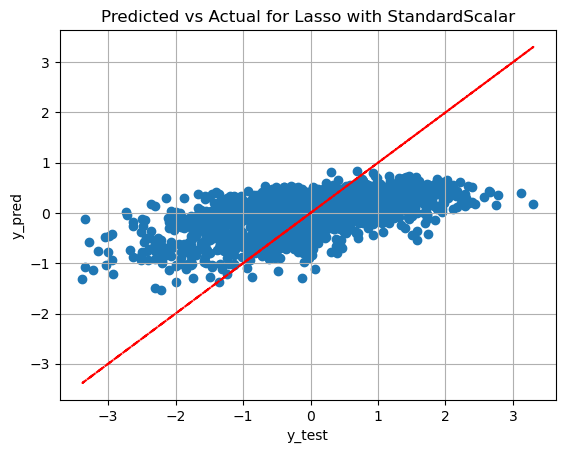

In [246]:
# from chatGPT!

import numpy as np
import matplotlib.pyplot as plt

def plot_predictions(y_test, y_pred, descrip_of_run):
    # Check if the arrays have the same length
    if len(y_test) != len(y_pred):
        raise ValueError("The input arrays must have the same length.")

    # Create a scatter plot
    plt.scatter(y_test, y_pred)
    plt.plot(y_test, y_test, color='red', linestyle='--')  # Line y_pred = y_test
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.title('Predicted vs Actual for ' + descrip_of_run)
    plt.grid(True)
    plt.show()

# Example usage
# y_test = np.array([1, 2, 3, 4, 5])
# y_pred = np.array([1.1, 1.9, 3.2, 3.8, 4.9])

plot_predictions(y_testST, y_predST, 'Lasso with StandardScalar')


<span style=color:blue>Let's try plain old linear regression    </span>

In [225]:
linearST = LinearRegression()

In [226]:
print(type(y_trainST))

linearST.fit(X_trainST,y_trainST)

<class 'numpy.ndarray'>


LinearRegression()

<span style=color:blue>As a small side note, when I first created the monthly ML table, I forgot to do one-hot encoding of the 3 soil columns.  Without the one-hot my rmseST was 0.704. So, three soil columns are providing a small boost.   </span>

0.6923776222399772


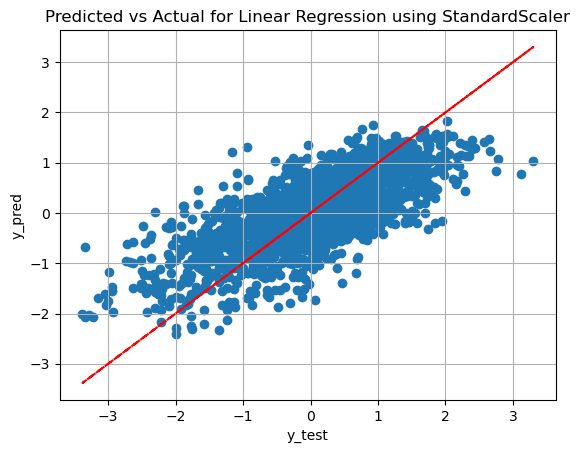

In [227]:
y_predST = linearST.predict(X_testST)

rmseST = math.sqrt(mean_squared_error(y_testST, y_predST))
print(rmseST)

plot_predictions(y_testST, y_predST, 'Linear Regression using StandardScaler')


### <span style=color:blue>I now switch to the MinMaxScaler.  A primary reason is so that I can use RRSME.  (Recall that the formula for RRSME is RSME/mean, but with StandardScalar the mean is set to 0 by design.)    </span>

In [229]:
scalerXMM = MinMaxScaler().fit(X_train)
scaleryMM = MinMaxScaler().fit(y_train)

X_trainMM = scalerXMM.transform(X_train)
y_trainMM = scaleryMM.transform(y_train)
X_testMM = scalerXMM.transform(X_test)
y_testMM = scaleryMM.transform(y_test)



<span style=color:blue>How to get back to original values of y_test when using MinMax ...    </span>

In [230]:
# testing how inverse of the scaling is working with MinMaxScaler

print(df_ml.iloc[7397]['yield'])   #  the first entry in y_test has index 1277 from df_ml
print(y_testMM[0])
print(scaleryMM.inverse_transform(y_testMM)[0])

39.6
[0.42937063]
[39.6]


<span style=color:blue>Now trying linear regression on MinMaxScaler      </span>

<span style=color:blue>Note: when I ran this without the one-hot soil columns, I get the values 0.0927668152923395, 0.185533630584679, 0.5171931008533303 for rmseMM, rrmseMM and r2MM, respectively <span style=color:red>

0.09055156997801181
0.18110313995602362
0.5399763690393666


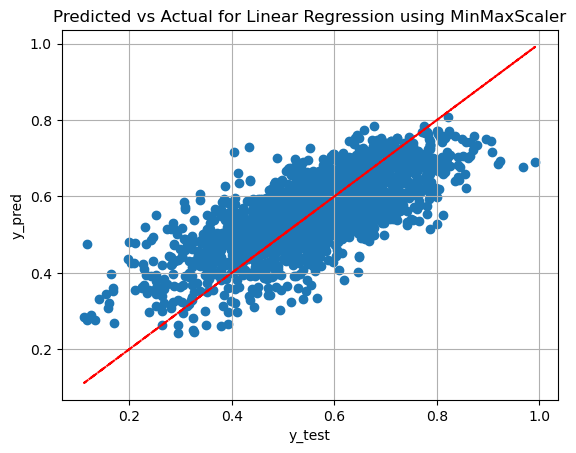

In [231]:
linearMM = LinearRegression()

linearMM.fit(X_trainMM,y_trainMM)

y_predMM = linearMM.predict(X_testMM)

rmseMM = math.sqrt(mean_squared_error(y_testMM, y_predMM))
rrmseMM = rmseMM / (0.5)
r2MM = r2_score(y_testMM, y_predMM)
print(rmseMM)
print(rrmseMM)
print(r2MM)


plot_predictions(y_testMM, y_predMM, 'Linear Regression using MinMaxScaler')



<span style=color:blue>Note: interestingly, the shape of the blue blob for linearMM looks identical to the shape of the blue blob for linearST.     </span>

### <span style=color:blue>Now trying random forest

0.11349253447526553
0.22698506895053105
0.2773587277559947


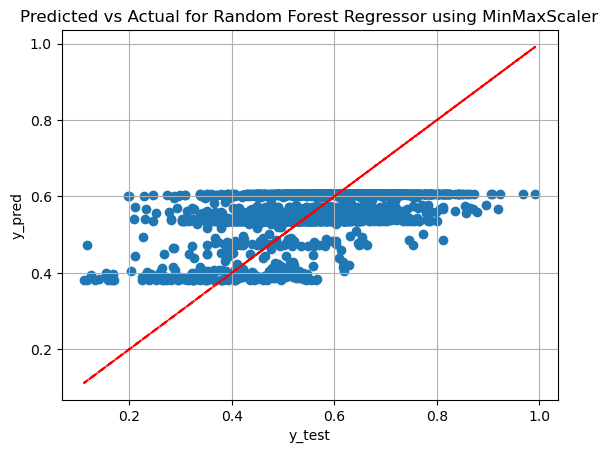

In [236]:
# random forest regressor
regrMM = RandomForestRegressor(max_depth=2, random_state=0)
#   with depth 2
#      0.11349253447526553
#      0.22698506895053105
#      0.2773587277559947
# regrMM = RandomForestRegressor(max_depth=10, random_state=0)
#   with depth 10:
#      0.06593145947060583
#      0.13186291894121166
#      0.7561214796081714
# regrMM = RandomForestRegressor(max_depth=20, random_state=0)
#   with depth 20:
#      0.06060039414793919
#      0.12120078829587838
#      0.7939659164434344

# for some reason, need to use y_trainMM.ravel() rather than simply y_trainMM
regrMM.fit(X_trainMM, y_trainMM.ravel())

y_predMM = regrMM.predict(X_testMM)
rmseMM = math.sqrt(mean_squared_error(y_testMM, y_predMM))
rrmseMM = rmseMM / (0.5)
r2MM = r2_score(y_testMM, y_predMM)
print(rmseMM)
print(rrmseMM)
print(r2MM)


plot_predictions(y_testMM, y_predMM, 'Random Forest Regressor using MinMaxScaler')


<span style=color:blue>Question: Why is it that with both Linear Regression and Random Forest the slope of the blue blob is more shallow than the slope of the red line?  Is there something we should do about it?     </span>